In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model

%matplotlib inline

/Applications/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
data = pd.read_csv('../../data/index_shanghai.csv', index_col='date', parse_dates=True)
data = data['19950101'::]
#data = pd.read_excel('../../data/500ETF_510500_1d_20151028.xlsx', index_col='date', parse_dates=True)

#### Return calculation
ret_cc = data['close'] / data['close'].shift(1) - 1
ret_co = data['close'] / data['open'] - 1
ret_oc = data['open'] / data['close'].shift(1) - 1
data['cc'] = ret_cc;
data['co'] = ret_co;
data['oc'] = ret_oc;
ret_all = data.ix[:, ('cc', 'co', 'oc')]

### cleaning
data = data.dropna()
ret_all = ret_all.dropna()

### 海龟交易法则－稳健投资策略评估方法
海龟交易法则书中提到几种评估稳健投资策略的方法：

1. RAR － Regressed Annual Return

RAR 比CAGR对于一个波动的净值曲线而言， 更能够稳定的测量该曲线的上涨幅度和回报率。 

In [3]:
def RAR(ret) :
    n = ret.count()
    nav = (1+ret).cumprod()
    cagr = (nav[-1]/nav[0] -1) / n 

    reg = linear_model.LinearRegression()
    X = np.array(range(n), ndmin=2).transpose();
    y = np.array(nav.data, ndmin=2).transpose()
    reg.fit(X, y)

    rar = (reg.predict(X[-1]) / reg.predict(X[0]) -1) / n
    rar = np.float64(rar)
    
    
    return cagr, rar, reg

def Sharpe(ret, annualized_factor = 365) :
    cagr, rar, reg = RAR(ret)
    cagr = cagr * annualized_factor
    rar = rar * annualized_factor
    vol = np.std(ret) * np.sqrt(annualized_factor)
    
    r_sharpe = rar / vol
    sharpe = cagr / vol
    return sharpe, r_sharpe




测试


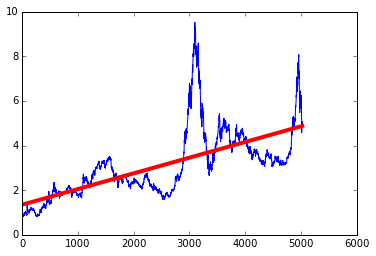

In [4]:
ret_test = ret_all['cc']
cagr, rar, reg = RAR(ret_test)

nav = (1+ret_test).cumprod()
X = np.array(range(nav.count()), ndmin=2).transpose();
    
plt.plot(nav)
plt.plot(X, reg.predict(X),color='red',linewidth=4)

In [21]:
[rar, cagr]
sharpe, r_sharpe = Sharpe(ret_test)
[sharpe, r_sharpe]
reg.coef_

array([[ 0.00070287]])

In [22]:
linear_model.LinearRegression?

In [ ]:
ret_test = ret_all['cc'][1:500]
cagr, rar, reg = RAR(ret_test)

nav = (1+ret_test).cumprod()
X = np.array(range(nav.count()), ndmin=2).transpose();
    
plt.plot(nav)
plt.plot(X, reg.predict(X),color='red',linewidth=4)

In [ ]:
[rar, cagr]

In [ ]:
sharpe, r_sharpe = Sharpe(ret)
sharpe1, r_sharpe1 = Sharpe(ret[1:1000])
[sharpe, r_sharpe, sharpe1, r_sharpe1]

2 稳健风险回报比例（robust risk/reward ratio)

In [ ]:
def MDD(ret, N) :
    ret = ret_cc.dropna()
    ret = ret[100::]
    nav = (1+ret).cumprod();
    high_wm = nav * 0 #high water mark


    for i in range(len(ret)) :
        if i == 0:
            high_wm[i] = nav[i]
        else:
            high_wm[i] = nav[i] if nav[i] > high_wm[i-1] else high_wm[i-1]

    dd = nav - high_wm ## drawdown curves

    ### determine the numbers of the drawdown periods, and their start/end index
    start = []
    end = []
    for j in range(len(dd)) :
        if j > 0:
            if dd[j] < 0 and dd[j - 1] == 0: 
                start.append(j);
            if dd[j] == 0 and dd[j -1] < 0:
                end.append(j);
            if dd[j] <0 and j == len(dd) - 1:
                end.append(j);

    ### drawdown percentage
    dd_pct = dd * 0
    n_dd = len(start)
    for k in range(n_dd):
        dd_pct[start[k]:end[k]] = nav[start[k]:end[k]] / nav[start[k]-1] - 1

    ###
    dd_size = []
    dd_duration = []
    n_dd = len(start)
    for k in range(n_dd):
        dd_size.append(min(dd_pct[start[k]:end[k]]))
        dd_duration.append(end[k] - start[k])

    ### top N largest drawdown
    max_dd_size = []
    max_dd_duration = []
    for l in range(N) :
        max_dd = min(dd_size)
        index = dd_size.index(max_dd)

        max_dd_size.append(dd_size.pop(index))
        max_dd_duration.append(dd_duration.pop(index))
        
    ### output
    return max_dd_size, max_dd_duration

 
### length_adjusted_MDD annualize MDD with their average length.
### the formula is : Average_Max_DD / Average_DD_Duration * Annulized_factor (365 by default, if days are using)
def length_adjusted_MDD(ret, N = 5, annulized_factor = 365) :
    max_dd_size, max_dd_duration = MDD(ret, N);
    avg_mdd = np.mean(max_dd_size)
    avg_mdd_duration = np.mean(max_dd_duration)
    
    la_MDD = avg_mdd / avg_mdd_duration * annulized_factor
    return la_MDD
    

In [ ]:
def RRR(ret, N = 5, annulized_factor = 365):
    cagr, rar, reg= RAR(ret)
    rar = rar * annulized_factor

    la_mdd = length_adjusted_MDD(ret, N, annulized_factor)
    rrr = rar / abs(la_mdd)
    return rrr

测试

In [ ]:
rrr = RRR(ret, 5)
rrr1 = RRR(ret, 10)
[rrr, rrr1]